# Climatology

In this tutorial, we'll look at how to use wxee to calculate long-term climatological means of gridded weather data. Currently, monthly and daily mean climatologies are supported.

## Setup

In [ ]:
!pip install wxee

In [1]:
import ee
import wxee

ee.Authenticate()
ee.Initialize()

## Create a Time Series

Time-based methods in wxee, like temporal aggregation and climatology, work with the `TimeSeries` subclass of `ee.ImageCollection`. To use them, we'll need to create a `TimeSeries`. There are two ways to do this.

### From an Image Collection
Create an `ee.ImageCollection` and use the `wx` accessor and the `to_time_series` method to convert the Image Collection to a `TimeSeries`. 

In [2]:
rtma = ee.ImageCollection("IDAHO_EPSCOR/GRIDMET")
ts = rtma.wx.to_time_series()

### From Scratch
As a shortcut, you can create a `TimeSeries` just like you would create an `ee.ImageCollection`. Just pass a collection ID or list of Images.

In [3]:
ts = wxee.TimeSeries("IDAHO_EPSCOR/GRIDMET")

## Monthly Total Rainfall

gridMET contains daily weather data including precipitation. First, we'll load 10 years of data from 2000 - 2010 into a `TimeSeries`, giving us several thousand daily images.

In [4]:
ts = ts.select("pr")
ts = ts.filterDate("2000", "2010")

ts.size().getInfo()

3653

Now, we'll calculate the monthly mean total rainfall over the 10 years, giving us just 12 images (one per month).

In [5]:
clim = ts.climatology_mean(frequency="month", reducer=ee.Reducer.sum())
clim.size().getInfo()

12

<div class="alert alert-block alert-info">
<b>Tip:</b> The reducer argument defines how data will be aggregated before the mean climatology is calculated. In this case, we'll sum the daily precipitation to get monthly totals. The mean monthly climatology will be calculated from those totals.
</div>

Finally, we'll download the monthly mean totals as an xarray dataset and plot them.

Requesting:   0%|          | 0/12 [00:00<?, ?it/s]

Downloading:   0%|          | 0/12 [00:00<?, ?it/s]

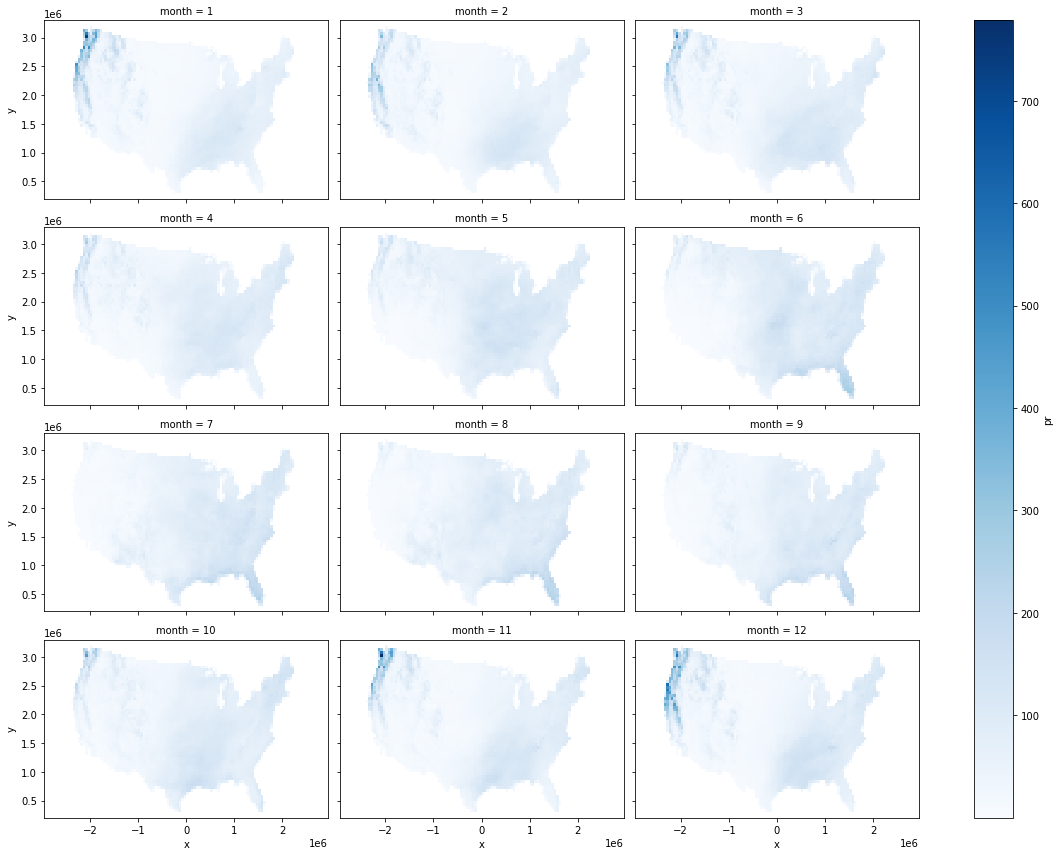

In [6]:
x = clim.wx.to_xarray(scale=50_000, crs="EPSG:5070")
x.pr.plot(col="month", col_wrap=3, figsize=(16, 12), cmap="Blues")

## Daily Mean Burning Index

Once again we'll look at gridMET daily weather data, but this time we'll calculate the climatological mean burning index (a measure of wildfire potential) by day-of-year. Day-of-year climatologies require processing a lot more data, so we'll just use 4 years for this example.

In [7]:
ts = wxee.TimeSeries("IDAHO_EPSCOR/GRIDMET").select("bi")
ts = ts.filterDate("2000", "2004")

A day-of-year climatology will give 366 images, one for each day through the 4 years (including leap days).

<div class="alert alert-block alert-warning">
<b>Note:</b>  Julian dates are used to calculate day-of-year means in wxee, so days after February 29 will be offset by one in leap years. For example, day-of-year 365 will represent December 31 in non-leap years and December 30 in leap years. Day 366 will always represent December 31, but will be aggregated from 1/4 as many days as other days of the year.
</div>

In [8]:
clim = ts.climatology_mean(frequency="day")
clim.size().getInfo()

366

We could download all 366 images, but maybe we're only interested in burning index for the month of August. We can use the `start` and `end` args to set the climatological window of days to look at. 

Here we'll set the `start` to 213 and the `end` to 243 (Aug. 1 and Aug. 31 in non-leap years). Now we only have 31 images.

In [9]:
clim = ts.climatology_mean(frequency="day", start=213, end=243)
clim.size().getInfo()

31

<div class="alert alert-block alert-info">
<b>Tip:</b> Downloading is the slowest part of dealing with Earth Engine data in wxee, so it's always best to aggregate and filter your data before downloading.
</div>

Let's download them.

In [10]:
aug_bi = clim.wx.to_xarray(scale=50_000, crs="EPSG:5070")

Requesting:   0%|          | 0/31 [00:00<?, ?it/s]

Downloading:   0%|          | 0/31 [00:00<?, ?it/s]

And finally, we'll plot a timeline of 95th percentile burning index values over the CONUS.

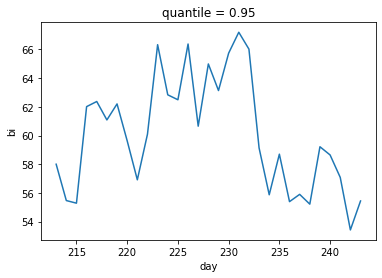

In [11]:
aug_bi.bi.quantile(0.95, ["x", "y"]).plot()